<a href="https://colab.research.google.com/github/glazar01/lyric-pulse-sentiment-analysis/blob/main/lyrics_analysis_model1_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 22 20:31:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 131.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 321.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 164.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 259.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 396.8 MB/s eta 0:00:00


In [ ]:
!pip3 install torch

In [ ]:
# import libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import torch

# Our Data (Multi Label)

Our data set's emotion labels:

'activation', 'amazement', 'calmness', 'joyful', 'nostalgia',
'power', 'sadness', 'solemnity', 'tenderness', and 'tension'

In [ ]:
url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/MultiLabel.csv"
m_data = pd.read_csv(url)

In [ ]:
m_data

,artist,genre,title,album,year,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension"
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,"Amazement, Calmness, Solemnity, Tenderness"
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...","Joyful activation, Sadness, Tension"
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,"Amazement, Calmness, Joyful activation"
...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,"Nostalgia, Sadness, Tenderness"
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,"Calmness, Power, Tenderness"
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,"Power, Solemnity, Tension"
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness


In [ ]:
y = m_data['labels']

In [ ]:
vectorizer = CountVectorizer()
emotion_dtm = vectorizer.fit_transform(y)
emotions = vectorizer.get_feature_names_out()
emotions

array(['activation', 'amazement', 'calmness', 'joyful', 'nostalgia',
       'power', 'sadness', 'solemnity', 'tenderness', 'tension'],
      dtype=object)

In [ ]:
freqs = emotion_dtm.sum(axis=0).A1
result = dict(zip(emotions, freqs))
freq_count = pd.DataFrame(result.items(), columns=['Emotions', 'Counts'])
freq_sorted = freq_count.sort_values(['Counts'], ascending=False)
freq_sorted

,Emotions,Counts
6,sadness,574
9,tension,553
8,tenderness,498
5,power,477
4,nostalgia,438
7,solemnity,377
0,activation,349
3,joyful,349
2,calmness,250
1,amazement,239


In [ ]:
emotion_per_example = emotion_dtm.sum(axis=1).tolist()
emotion_per_example = [int(j) for i in emotion_per_example for j in i]
print('Maximum emotions per example: %d'%max(emotion_per_example))
print('Minimum emotions per example: %d'%min(emotion_per_example))
print('Average emotions per example: %f'% ((sum(emotion_per_example))/len(emotion_per_example)))

Maximum emotions per example: 8
Minimum emotions per example: 1
Average emotions per example: 3.537931


# Model 2: roberta-base-go_emotions

## link
https://huggingface.co/SamLowe/roberta-base-go_emotions?text=I+love+you

## description:
Model trained from roberta-base on the go_emotions dataset for multi-label classification.

## emotion categories
love,
admiration,
approval,
neutral,
joy,
optimism,
gratitude,
desire,
annoyance,
caring,
disapproval,
anger,
realization,
sadness,
excitement,
disappointment,
amusement,
confusion,
disgust,
curiosity,
surprise,
remorse,
fear,
nervousness,
embarrassment,
grief,
pride,
and relief

## Note
neutral emotion --> ignore

In [ ]:
from transformers import pipeline

classifier_2 = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

In [ ]:
prediction_0 = classifier_2(m_data['lyrics'][0],)

In [ ]:
prediction_0

[[{'label': 'approval', 'score': 0.5469815731048584},
  {'label': 'neutral', 'score': 0.3794182538986206},
  {'label': 'realization', 'score': 0.04105584695935249},
  {'label': 'annoyance', 'score': 0.03877567872405052},
  {'label': 'anger', 'score': 0.011280348524451256},
  {'label': 'disapproval', 'score': 0.009934008121490479},
  {'label': 'admiration', 'score': 0.009317492134869099},
  {'label': 'caring', 'score': 0.008861226961016655},
  {'label': 'optimism', 'score': 0.008721140213310719},
  {'label': 'love', 'score': 0.008435306139290333},
  {'label': 'fear', 'score': 0.007663650903850794},
  {'label': 'excitement', 'score': 0.007383411284536123},
  {'label': 'joy', 'score': 0.006509275641292334},
  {'label': 'disappointment', 'score': 0.005609462037682533},
  {'label': 'sadness', 'score': 0.0035841010976582766},
  {'label': 'relief', 'score': 0.0033677532337605953},
  {'label': 'surprise', 'score': 0.0031086921226233244},
  {'label': 'pride', 'score': 0.002746881451457739},
  {

In [ ]:
BATCH_SIZE = 32  # can be adjusted
classifier_2_emotions = ['love', 'admiration', 'approval', 'neutral', 'joy', 'optimism', 'gratitude', 'desire', 'annoyance', 'caring', 'disapproval', 'anger', 'realization', 'sadness', 'excitement', 'disappointment', 'amusement', 'confusion', 'disgust', 'curiosity', 'surprise', 'remorse', 'fear', 'nervousness', 'embarrassment', 'grief', 'pride', 'relief']

In [ ]:
# Define a function to get sentiment scores for a lyric split by paragraphs
def get_sentiment_scores_by_sentences(lyric, classifier, classifier_emotions):
    aggregated_scores = dict.fromkeys(classifier_emotions, 0)
    sentences = [p for p in lyric.split('\n') if p]  # Split by sentences and remove empty ones

    # Process sentences in batches
    for i in range(0, len(sentences), BATCH_SIZE):
        batch = sentences[i:i+BATCH_SIZE]
        results_batch = classifier(batch)

        for result in results_batch:
          for res in result:
            label = res['label']
            score = res['score']
            aggregated_scores[label] += score

    # Average the scores
    num_sentences = len(sentences)
    for label in aggregated_scores:
        aggregated_scores[label] /= num_sentences

    return aggregated_scores

In [ ]:
m_data['lyrics'][0]

"I will never bother you\nI will never promise to\nI will never follow you\nI will never bother you\nNever speak a word again\nI will crawl away for good\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAnd always knew it would come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eeey\nHe-eee-eee-eey\nHe-eee-eee-ey\nYou know you're right\nYou know you're right\nYou know you're right\n\nI'm so warm and calm inside\nI no longer have to hide\nLet's talk about someone else\nSteaming soup against her mouth\nNothing really bothers her\nShe just wants to love himself\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAlways knew it'd come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nYou know you're right\nYou know you're right\nYou know you're right\nYou know you're right\nYou

In [ ]:
test_scores = get_sentiment_scores_by_sentences(m_data['lyrics'][0], classifier_2, classifier_2_emotions)
test_scores

{'love': 0.00561858203270406,
 'admiration': 0.016255596348076193,
 'approval': 0.2951903312516931,
 'neutral': 0.49983849549399956,
 'joy': 0.021785020065310943,
 'optimism': 0.018005765752085217,
 'gratitude': 0.0018999510071548034,
 'desire': 0.00616005843039602,
 'annoyance': 0.016164584168499068,
 'caring': 0.03422018859315098,
 'disapproval': 0.02987910493227121,
 'anger': 0.005264533536059649,
 'realization': 0.028738913841412535,
 'sadness': 0.005650712000455574,
 'excitement': 0.012267719829521542,
 'disappointment': 0.008587261296010442,
 'amusement': 0.0051212529932464735,
 'confusion': 0.0028668079134409447,
 'disgust': 0.0021864870577701367,
 'curiosity': 0.0036769953107328285,
 'surprise': 0.010295141146863378,
 'remorse': 0.000719140193853361,
 'fear': 0.004003652707199633,
 'nervousness': 0.0012580767639259907,
 'embarrassment': 0.0013306009134664367,
 'grief': 0.0007055784049693362,
 'pride': 0.0016000481799502658,
 'relief': 0.0036930465225201}

In [ ]:
max(test_scores, key= lambda x: test_scores[x])

'neutral'

In [ ]:
# Process the dataset (38mins)
sentiment_scores = [get_sentiment_scores_by_sentences(lyric, classifier_2, classifier_2_emotions) for lyric in m_data['lyrics']]

In [ ]:
def find_max_key(sentiment_scores, ignore_key='neutral'):
    second_max_keys = []
    for lyric_sentiment_scores in sentiment_scores:
        sorted_keys = sorted(lyric_sentiment_scores, key=lambda x: lyric_sentiment_scores[x], reverse=True)
        if sorted_keys[0] == ignore_key:
            # If the first key is 'Ignore,' we consider the second key
            second_max_keys.append(sorted_keys[1])
        else:
            second_max_keys.append(sorted_keys[0])
    return second_max_keys

In [ ]:
dominant_sentiments = find_max_key(sentiment_scores, ignore_key='neutral')
dominant_sentiments[0]

'approval'

In [ ]:
# Add results to the DataFrame
m_data['sentiment_scores'] = sentiment_scores
m_data['dominant_sentiment'] = dominant_sentiments

In [ ]:
m_data

,artist,genre,title,album,year,lyrics,labels,sentiment_scores,dominant_sentiment
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,"Calmness, Sadness","{'love': 0.00561858203270406, 'admiration': 0....",approval
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension","{'love': 0.012855785761968474, 'admiration': 0...",approval
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,"Amazement, Calmness, Solemnity, Tenderness","{'love': 0.0018713925178707677, 'admiration': ...",approval
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...","Joyful activation, Sadness, Tension","{'love': 0.002537756721721962, 'admiration': 0...",joy
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,"Amazement, Calmness, Joyful activation","{'love': 0.0017250501154731103, 'admiration': ...",approval
...,...,...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,"Nostalgia, Sadness, Tenderness","{'love': 0.05435733493262281, 'admiration': 0....",approval
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,"Calmness, Power, Tenderness","{'love': 0.18108249476063065, 'admiration': 0....",love
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,"Power, Solemnity, Tension","{'love': 0.0010456891322974116, 'admiration': ...",sadness
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness,"{'love': 0.08135246273741359, 'admiration': 0....",admiration


In [ ]:
m_data['sentiment_scores'][1159]

{'love': 0.030052817882581923,
 'admiration': 0.01107407388785346,
 'approval': 0.10686184398152611,
 'neutral': 0.610513033514673,
 'joy': 0.051221848446099706,
 'optimism': 0.01111641395695959,
 'gratitude': 0.03104584753799083,
 'desire': 0.002338871052912013,
 'annoyance': 0.017115873404580987,
 'caring': 0.02762684675734349,
 'disapproval': 0.014446913550438529,
 'anger': 0.004998145482121882,
 'realization': 0.04201035763870812,
 'sadness': 0.01125948783980372,
 'excitement': 0.00521888756228498,
 'disappointment': 0.011803908728655766,
 'amusement': 0.06522311900467188,
 'confusion': 0.041439074465553415,
 'disgust': 0.0018277207943328628,
 'curiosity': 0.008631689809121643,
 'surprise': 0.0032894945347145426,
 'remorse': 0.0009461306158989443,
 'fear': 0.0014391321226756907,
 'nervousness': 0.001043385161513773,
 'embarrassment': 0.0011348493227904494,
 'grief': 0.0006694614267237766,
 'pride': 0.0009757761047997823,
 'relief': 0.0020871671982935036}

In [ ]:
m_data['labels'][1159]

'Amazement, Calmness, Nostalgia, Power'

## Mapping


---
note: we can also calculte different accuracies if we categorize "surprise" into different categories



In [ ]:
emotion_mapping = {
    'love' : 'Tenderness',
    'admiration' : 'Amazement',
    'approval' : 'Power',
    'joy' : 'Joyful',
    'optimism' : 'Activation',
    'gratitude' : 'Power',
    'desire' : 'Nostalgia',
    'annoyance' : 'Tension',
    'caring' : 'Tenderness',
    'disapproval' : 'Tension',
    'anger' : 'Tension',
    'realization' : 'Solemnity',
    'sadness' : 'Sadness',
    'excitement' : 'Joyful',
    'disappointment' : 'Sadness',
    'amusement' : 'Joyful',
    'confusion' : 'Tension',
    'disgust' : 'Tension',
    'curiosity' : 'Tension',
    'surprise' : 'Amazement',
    'remorse' : 'Sadness',
    'fear' : 'Tension',
    'nervousness' : 'Tension',
    'embarrassment' : 'Tension',
    'grief' : 'Sadness',
    'pride' : 'Activation',
    'relief' : 'Tenderness'
}

In [ ]:
mapped_predictions = [emotion_mapping[dominant] for dominant in m_data['dominant_sentiment']]

In [ ]:
m_data['mapped_emotion'] = mapped_predictions

In [ ]:
original_emotions = m_data['labels']
correct_predictions = sum(predicted in {word.strip() for word in original.split(',')} for original, predicted in zip(original_emotions, mapped_predictions))

accuracy_m2_m = correct_predictions / len(m_data)

In [ ]:
accuracy_m2_m

0.5836206896551724

# Visualizations

In [ ]:
pip install matplotlib seaborn

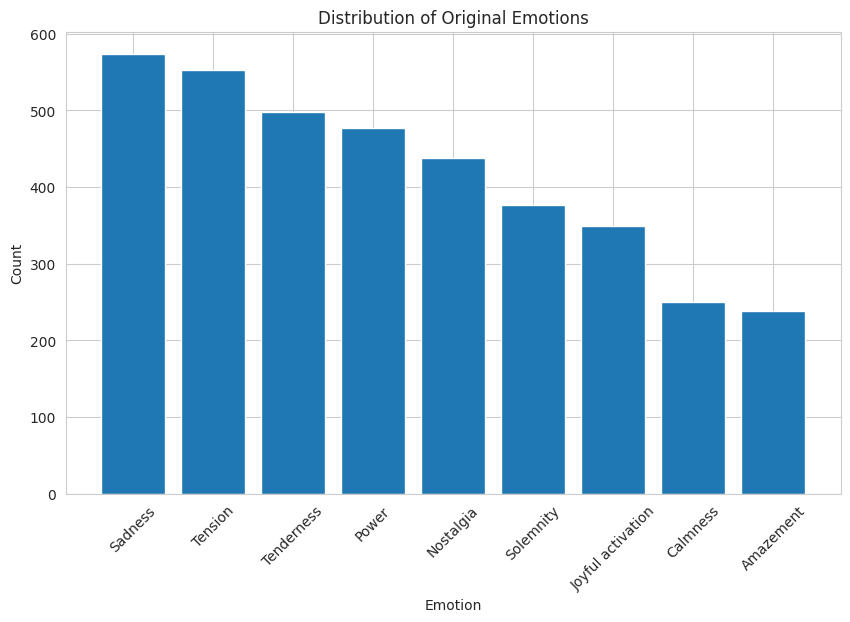

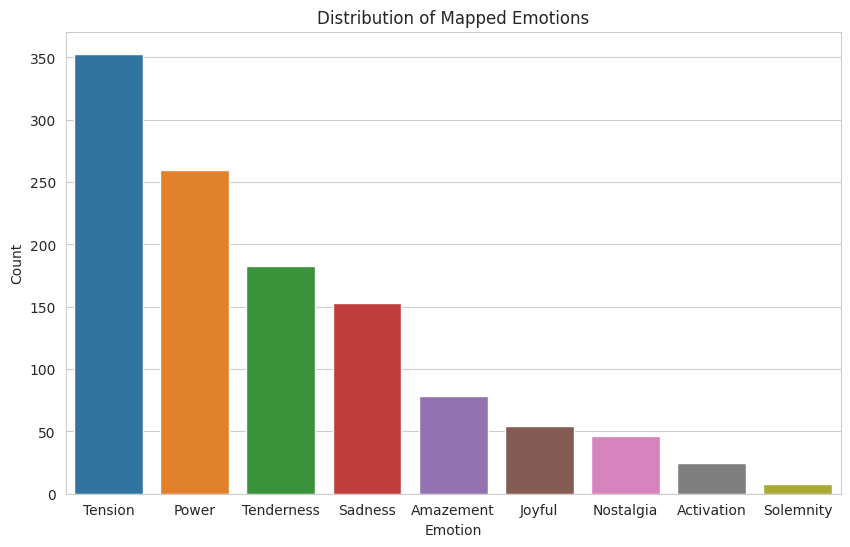

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set_style("whitegrid")

# Split the strings into individual emotions
all_emotions = [emotion.strip() for labels in m_data['labels'] for emotion in labels.split(',')]

# Count the occurrences of each emotion
emotion_counts = pd.Series(all_emotions).value_counts()

# Plot for original_emotion distribution
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Original Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Plot for mapped_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=m_data, x='mapped_emotion', order=m_data['mapped_emotion'].value_counts().index)
plt.title('Distribution of Mapped Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

<ipython-input-58-6bcb3a720b99>:10: RuntimeWarning: invalid value encountered in divide
  accuracies = cm.diagonal() / cm.sum(axis=1)


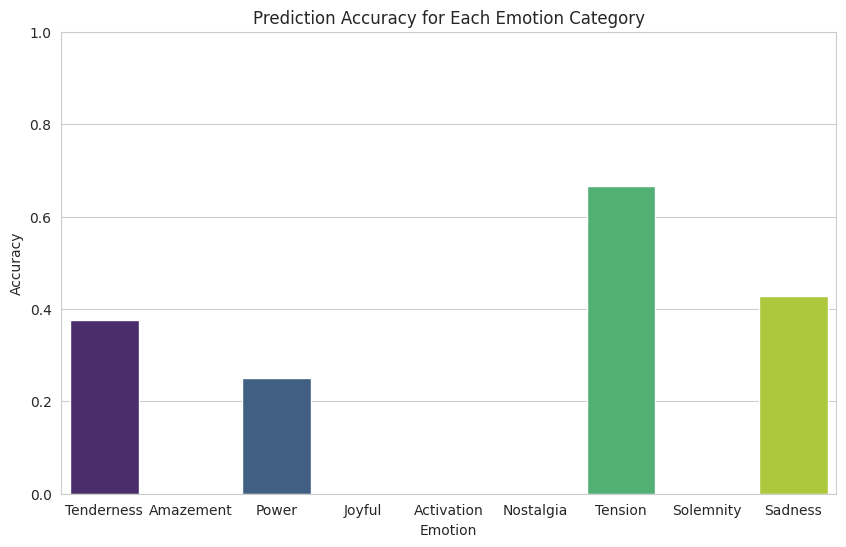

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(original_emotions, mapped_predictions, labels=list(emotion_mapping.values()))

# Calculate per-category accuracy
accuracies = cm.diagonal() / cm.sum(axis=1)

# Mapping of emotions to their accuracies
emotion_accuracy = dict(zip(list(emotion_mapping.values()), accuracies))

# Visualize the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy.keys()), y=list(emotion_accuracy.values()), palette="viridis")
plt.title('Prediction Accuracy for Each Emotion Category')
plt.ylabel('Accuracy')
plt.xlabel('Emotion')
plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
plt.show()